# Quantization

In [ ]:
import torch
import bitsandbytes as bnb
import gc
import matplotlib.pyplot as plt

def print_gpu_utilization():
    allocated = torch.cuda.memory_allocated() / (1024 ** 2)
    reserved = torch.cuda.memory_reserved() / (1024 ** 2)
    print(f"GPU Memory Usage>>>> Allocated: {allocated:.2f} MB |||||  Reserved:  {reserved:.2f} MB:")

def flush():
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()

# Create a simple 10000x10000 float32 tensor
tensor_fp32 = torch.randn(10000, 10000, dtype=torch.float32).cuda()
print_gpu_utilization()

print(f"Original dtype: {tensor_fp32.dtype}")

# Quantize to 8-bit using bitsandbytes
# bnb.nn.Int8Params is designed to store tensors in int8
quantized_tensor = bnb.functional.quantize_4bit(tensor_fp32)

del tensor_fp32
flush()

print_gpu_utilization()


GPU Memory Usage>>>> Allocated: 382.00 MB |||||  Reserved:  382.00 MB:
Original dtype: torch.float32
GPU Memory Usage>>>> Allocated: 53.96 MB |||||  Reserved:  70.00 MB:


Original: tensor([[-0.1755,  0.7386,  0.2404,  ..., -1.2353, -0.3529,  0.1440],
        [-0.0735, -0.9209,  0.9531,  ...,  0.1660,  1.7103,  0.2442],
        [ 1.1087,  0.7899,  0.1461,  ...,  0.3863,  1.4779,  1.2505],
        ...,
        [ 0.9259, -0.0159, -0.3909,  ..., -0.4151,  0.3180, -0.3785],
        [-1.0048,  0.8912,  1.4854,  ...,  0.9281,  0.7023, -0.3175],
        [ 0.4238, -1.1607,  0.3622,  ..., -0.7286,  0.3647,  1.2309]],
       device='cuda:0') 

Quantized: tensor([[148],
        [110],
        [ 17],
        ...,
        [ 23],
        [220],
        [ 98]], device='cuda:0', dtype=torch.uint8) 

Dequantized: tensor([[-0.0129,  0.8258,  0.4129,  ..., -1.1632, -0.3877,  0.0121],
        [-0.0121, -0.7755,  0.7755,  ...,  0.0133,  1.6977,  0.4244],
        [ 1.2733,  0.8488,  0.0133,  ...,  0.3926,  1.5705,  1.1779],
        ...,
        [ 1.0470, -0.0164, -0.5235,  ..., -0.4418,  0.4418, -0.4418],
        [-0.8837,  0.8837,  1.3255,  ...,  0.7940,  0.7940, -0.3970],
 

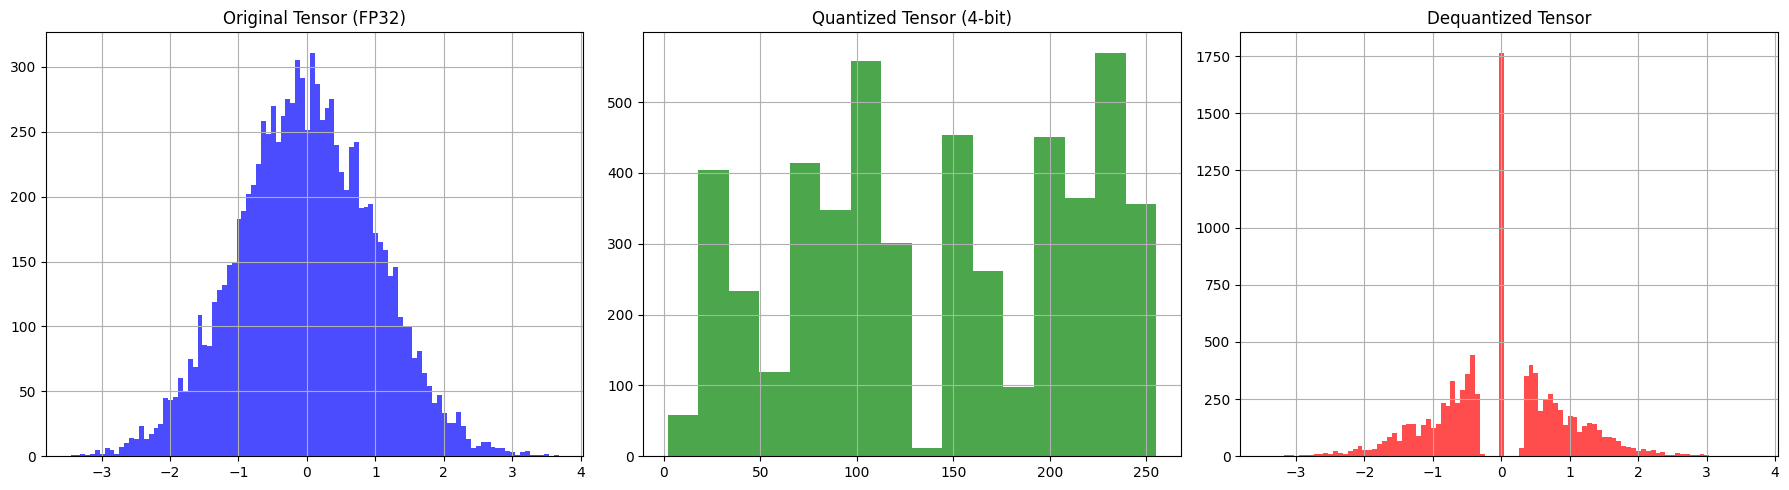

In [2]:
tensor_fp32 = torch.randn(100, 100, dtype=torch.float32).cuda()
print(f"Original: {tensor_fp32} \n")

quantized_tensor = bnb.functional.quantize_4bit(tensor_fp32)
print(f"Quantized: {quantized_tensor[0]} \n")

dequantized_tensor = bnb.functional.dequantize_4bit(quantized_tensor[0],quantized_tensor[1])
print(f"Dequantized: {dequantized_tensor} \n")

# Move everything to CPU for easier plotting
tensor_fp32_cpu = tensor_fp32.detach().cpu().flatten()
quantized_tensor_cpu = quantized_tensor[0].detach().cpu().flatten()
dequantized_tensor_cpu = dequantized_tensor.detach().cpu().flatten()

# Plot histograms
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.hist(tensor_fp32_cpu.numpy(), bins=100, color='blue', alpha=0.7)
plt.title('Original Tensor (FP32)')
plt.grid(True)

plt.subplot(1,3,2)
plt.hist(quantized_tensor_cpu.numpy(), bins=16, color='green', alpha=0.7)
plt.title('Quantized Tensor (4-bit)')
plt.grid(True)

plt.subplot(1,3,3)
plt.hist(dequantized_tensor_cpu.numpy(), bins=100, color='red', alpha=0.7)
plt.title('Dequantized Tensor')
plt.grid(True)

plt.tight_layout()
plt.show()

# Low Rank Adaptation (LoRA)
![LoRA Concept](./images/lora.png)

In [10]:
W = torch.randn(1000, 1000, dtype=torch.float32).cuda()
print(f'Total parameters to optimize: {torch.numel(W)}')

rank = 16
A = torch.randn(1000, rank, dtype=torch.float32).cuda()
B = torch.randn(rank, 1000, dtype=torch.float32).cuda()
print(f'LoRA parameters to optimize: {torch.numel(A)+torch.numel(B)}')
print(f'{(torch.numel(A)+torch.numel(B))/torch.numel(W)*100:.2f}% of total parameters')

# Compute W = A @ B
W_lora = A @ B
print(torch.numel(W_lora))


Total parameters to optimize: 1000000
LoRA parameters to optimize: 32000
3.20% of total parameters
1000000


# Finetuning the LLAMA 3.2 with Pure Pytorch and Using QLoRA

![QLORA](images/schema_QLORA.png)

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, get_scheduler
from bitsandbytes.optim import Adam8bit,PagedAdam32bit
from peft import LoraConfig, get_peft_model, PeftModel, PeftConfig
from peft import prepare_model_for_kbit_training
import torch
from IPython.display import  clear_output
import time
import gc
from torch.utils.data import Dataset, DataLoader

def print_gpu_utilization():
    allocated = torch.cuda.memory_allocated() / (1024 ** 2)
    reserved = torch.cuda.memory_reserved() / (1024 ** 2)
    print(f"GPU Memory Usage>>>> Allocated: {allocated:.2f} MB |||||  Reserved:  {reserved:.2f} MB:")

def flush():
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

DEFAULT_MODEL = "meta-llama/Llama-3.2-1B-Instruct"

bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type='nf4',
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=False,
    )


model = AutoModelForCausalLM.from_pretrained(
    DEFAULT_MODEL,
    quantization_config=bnb_config,
    use_safetensors=True,
    device_map=device,
)

print(model.get_memory_footprint()/(1024*1024)) 

tokenizer = AutoTokenizer.from_pretrained(DEFAULT_MODEL, use_safetensors=True)
tokenizer.pad_token_id = tokenizer.eos_token_id
model.config.pad_token_id = tokenizer.eos_token_id


965.1290283203125


# Load an Instruction Finetuned Dataset

In [2]:
from datasets import load_dataset

# Load the dataset
# dataset = load_dataset("OdiaGenAI/hardcode_odia_qa_105")
dataset = load_dataset('OdiaGenAI/odia_domain_context_train_v1')

In [3]:
small_dataset=[]

for example in dataset['train']:
    small_dataset.append({
        "instruction": example['instruction'],
        "output": example['output']
    })
    
small_dataset[0]

{'instruction': 'ଓଡ଼ିଶାର ଅର୍ଥନୀତି ଉପରେ ପର୍ଯ୍ୟଟନର କିଭଳି ପ୍ରଭାବ ପଡ଼ିଛି?',
 'output': 'ବିଗତ କିଛି ବର୍ଷ ମଧ୍ୟରେ ପର୍ଯ୍ୟଟନ ଶିଳ୍ପ ଦ୍ୱାରା ଓଡ଼ିଶାର ଅର୍ଥନୀତି ବ୍ୟାପକ ଭାବେ ପ୍ରଭାବିତ ହୋଇଛି। ରାଜ୍ୟରେ ପ୍ରାକୃତିକ ସୌନ୍ଦର୍ଯ୍ୟ ଏବଂ ସାଂସ୍କୃତିକ ଐତିହ୍ୟ ସ୍ଥାନ ରହିଛି, ଯାହା ଦେଶ ଏବଂ ଦେଶ ବାହାରର ପର୍ଯ୍ୟଟକଙ୍କ ପାଇଁ ଆକର୍ଷଣୀୟ ହୋଇପାରିଛି।\nପର୍ଯ୍ୟଟନ କ୍ଷେତ୍ରରେ କାର୍ଯ୍ୟ କରୁଥିବା ଲୋକମାନଙ୍କ ପାଇଁ ନିଯୁକ୍ତି ସୁଯୋଗ ଏବଂ ଆୟ ବୃଦ୍ଧି ପାଇଛି, ଯେଉଁଥିରେ ଆତିଥ୍ୟ, ଟୁର ଅପରେଟର ଏବଂ ପରିବହନ ଶିଳ୍ପ ସାମିଲ ରହିଛି। ପର୍ଯ୍ୟଟନ ଶିଳ୍ପ ସ୍ଥାନୀୟ ଖାଦ୍ୟ, ହସ୍ତଶିଳ୍ପ ଏବଂ ସାଂସ୍କୃତିକ ଗତିବିଧିକୁ ପ୍ରୋତ୍ସାହିତ କରିବାରେ ସହାୟତା କରିଛି, ଯାହାକି ଓଡ଼ିଶାର ସାମଗ୍ରିକ ଅର୍ଥନୀତି ଉପରେ ସକାରାତ୍ମକ ପ୍ରଭାବ ପକାଇଛି।\nପର୍ଯ୍ୟଟକମାନଙ୍କ ପାଇଁ ଉତ୍ତମ ଅନୁଭୂତି ସୁନିଶ୍ଚିତ କରିବା ପାଇଁ ଭିତ୍ତିଭୂମି ବିକାଶ ଉପରେ ମଧ୍ୟ ସରକାର ଗୁରୁତ୍ୱ ଦେଉଛନ୍ତି। ସଡ଼କ ଏବଂ ସାର୍ବଜନୀନ ପରିବହନ ବ୍ୟବସ୍ଥାରେ ସୁଧାର କରାଯାଇଛି, ଯେତେବେଳେ କି ରାଜ୍ୟର ଅନେକ କ୍ଷେତ୍ରରେ ବିଭିନ୍ନ ଇକୋ-ଟୁରିଜମ ପ୍ରକଳ୍ପର ବିକାଶ କରାଯାଇଛି।\nଶେଷରେ ପର୍ଯ୍ୟଟନ ଓଡ଼ିଶାର ଆର୍ଥିକ ବିକାଶକୁ ତ୍ୱରାନ୍ୱିତ କରିବାରେ ଗୁରୁତ୍ୱପୂର୍ଣ୍ଣ ଭୂମିକା ନିର୍ବାହ କରିଛି ଏବଂ ରାଜ୍ୟବାସୀଙ୍କ ପାଇଁ ଅନେକ ଲାଭ ଆଣିପାରିଛି।'}

In [4]:
small_dataset = [
  {
    "instruction": "Summarize the IPL 2024 season.",
    "output": "The 2024 Indian Premier League (IPL) was a thrilling season filled with memorable moments, outstanding performances, and intense competition. Kolkata Knight Riders (KKR) emerged as the champions, defeating Sunrisers Hyderabad (SRH) in the final. The season witnessed remarkable individual performances, high-scoring matches, and competitive qualifier stages."
  },
  {
    "instruction": "Who won the IPL in 2024?",
    "output": "Kolkata Knight Riders (KKR) won the IPL in 2024."
  },
  {
    "instruction": "Which teams played in the final of IPL 2024?",
    "output": "Kolkata Knight Riders (KKR) and Sunrisers Hyderabad (SRH) played in the final of IPL 2024."
  },
  {
    "instruction": "Describe the performance of Kolkata Knight Riders in IPL 2024.",
    "output": "Kolkata Knight Riders (KKR) showcased dominant performances throughout the season and emerged as the champions, defeating Sunrisers Hyderabad (SRH) in the final to clinch their third IPL title."
  },
  {
    "instruction": "What were some of the key highlights of IPL 2024?",
    "output": "Some of the key highlights of IPL 2024 include Kolkata Knight Riders (KKR) winning the tournament, dominant performances from several teams, remarkable individual performances from both batsmen and bowlers, and many high-scoring matches."
  },
    {
    "instruction": "How were the qualifier matches in IPL 2024?",
    "output": "The qualifier matches in IPL 2024 were very competitive. KKR and SRH both displayed strong performances to reach the final. Royal Challengers Bengaluru (RCB) and Rajasthan Royals (RR) also played well in the eliminator stages."
  },
  {
    "instruction": "What was special about the final match of IPL 2024?",
    "output": "The final match of IPL 2024 was a highly anticipated clash between Kolkata Knight Riders and Sunrisers Hyderabad. KKR dominated the match, securing a comfortable victory and winning the IPL title."
  },
  {
    "instruction": "Did IPL 2024 have any last ball thrillers?",
    "output": "Yes, many matches throughout the IPL 2024 season had nail-biting finishes, with last-ball thrillers and unexpected comebacks."
  },
  {
    "instruction": "How was the performance of young cricketers in IPL 2024?",
    "output": "The IPL 2024 tournament showcased a mix of experienced players and emerging talent, with several young cricketers making a mark."
  },
  {
      "instruction": "Write a summary of IPL 2024",
      "output": "The 2024 IPL season was a thrilling and successful tournament, filled with excitement, drama, and outstanding cricket. Kolkata Knight Riders won the title, defeating Sunrisers Hyderabad in the final.  Many matches featured high scores and nail-biting finishes.  The tournament showcased a mix of experienced and young talented players."
  }
]

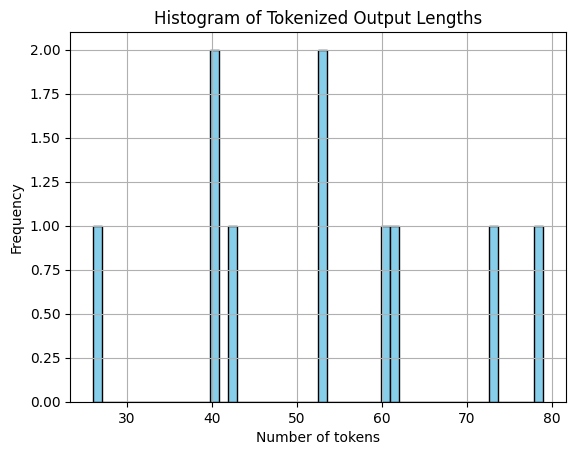

In [5]:
import matplotlib.pyplot as plt
lengths = [len(tokenizer(example['instruction']+example['output'])['input_ids']) for example in small_dataset]

# Plot the histogram
plt.hist(lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Tokenized Output Lengths")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [6]:
from transformers import pipeline

llama_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

messages = [
    {"role": "user", "content": small_dataset[0]['instruction']},
]

generated_text = llama_pipeline(messages, max_new_tokens=60, early_stopping=True)

print(generated_text[0]['generated_text'])

Device set to use cuda
/home/mohan.dash/miniconda3/envs/diffusion_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:679: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


[{'role': 'user', 'content': 'Summarize the IPL 2024 season.'}, {'role': 'assistant', 'content': "I'm happy to provide a summary of the IPL 2024 season. However, please note that I'm a large language model, I don't have have access to real-time information or the latest updates. My training data only goes up to 2022.\n\nThat being said, I can provide"}]


## Create the Dataset Object for Pytorch-Dataset

In [7]:
# Custom PyTorch Dataset
class LlamaDataset(Dataset):
    def __init__(self, dataset):
        self.data = dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        question=sample['instruction']
        answer = sample['output']
        prompt = f'''<|begin_of_text|> <|start_header_id|>user<|end_header_id|>\n\n{question}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n'''
        full_text = prompt+f'''{answer}<|eot_id|>'''

        tokenized = tokenizer(full_text, truncation=True, add_special_tokens=False, padding="max_length", max_length=200)

        input_ids = tokenized["input_ids"]
        attention_mask = tokenized["attention_mask"]

        # Tokenize just the prompt to get the split point
        prompt_ids = tokenizer(prompt, add_special_tokens=False)["input_ids"]
        answer_start = len(prompt_ids)

        # Mask everything before answer_start
        labels = [-100] * answer_start + input_ids[answer_start:]
        # Mask out padding as well
        labels = [
            label if token != tokenizer.pad_token_id else -100
            for label, token in zip(labels, input_ids)
        ]
    
        return {
        "input_ids": torch.tensor(input_ids),
        "attention_mask": torch.tensor(attention_mask),
        "labels": torch.tensor(labels)
    }
        

In [8]:
train_dataset = LlamaDataset(small_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [9]:
config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
)

model = get_peft_model(model, config)



model.print_trainable_parameters()

trainable params: 11,272,192 || all params: 1,247,086,592 || trainable%: 0.9039


In [10]:
for param in model.named_parameters():
    print(param[0],' dtype:',param[1].dtype, ' requirs grad: ',param[1].requires_grad)

base_model.model.model.embed_tokens.weight  dtype: torch.float16  requirs grad:  False
base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight  dtype: torch.uint8  requirs grad:  False
base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight  dtype: torch.float32  requirs grad:  True
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight  dtype: torch.float32  requirs grad:  True
base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight  dtype: torch.uint8  requirs grad:  False
base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight  dtype: torch.float32  requirs grad:  True
base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight  dtype: torch.float32  requirs grad:  True
base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight  dtype: torch.uint8  requirs grad:  False
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight  dtype: torch.float32  requirs grad:  True
base_model.model

In [11]:
# Now manually move LoRA params to bf16
for name, param in model.named_parameters():
    if "lora_" in name:
        param.data = param.data.to(torch.bfloat16)
        if param.requires_grad:
            param.grad = None  # Reset grads just in case

for param in model.named_parameters():
    print(param[0],' dtype:',param[1].dtype, ' requirs grad: ',param[1].requires_grad)

base_model.model.model.embed_tokens.weight  dtype: torch.float16  requirs grad:  False
base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight  dtype: torch.uint8  requirs grad:  False
base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight  dtype: torch.bfloat16  requirs grad:  True
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight  dtype: torch.bfloat16  requirs grad:  True
base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight  dtype: torch.uint8  requirs grad:  False
base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight  dtype: torch.bfloat16  requirs grad:  True
base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight  dtype: torch.bfloat16  requirs grad:  True
base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight  dtype: torch.uint8  requirs grad:  False
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight  dtype: torch.bfloat16  requirs grad:  True
base_model.

# Finetune the LLAMA model on a single text

In [12]:
def generate_eval(model,idx=5,disable_lora=False):
    
    model.config.use_cache = True
    sample=small_dataset[idx]
    question=sample['instruction']
    answer = sample['output']
    chat_template = f'''<|begin_of_text|> <|start_header_id|>user<|end_header_id|>\n\n{question}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n'''
    inputs = tokenizer(chat_template , return_tensors="pt", add_special_tokens=False).to(device)
    # print(prompt)

    model.eval()


    if disable_lora:
        with model.disable_adapter():
            output = model.generate(
                **inputs,
                do_sample=True,
                max_new_tokens=60,
                repetition_penalty=1.3,
                temperature=0.7,         # Optional: smooth randomness
                top_k=50,                # Optional: top-k sampling
                top_p=0.9                # Optional: nucleus sampling
            )
    else:
        output = model.generate(
        **inputs,
        do_sample=True,
        max_new_tokens=60,
        repetition_penalty=1.3,
        temperature=0.7,         # Optional: smooth randomness
        top_k=50,                # Optional: top-k sampling
        top_p=0.9                # Optional: nucleus sampling
        )

    processed_text = tokenizer.decode(output[0], skip_special_tokens=False)
    
    model.train()

    return processed_text

In [13]:
small_dataset[4]

{'instruction': 'What were some of the key highlights of IPL 2024?',
 'output': 'Some of the key highlights of IPL 2024 include Kolkata Knight Riders (KKR) winning the tournament, dominant performances from several teams, remarkable individual performances from both batsmen and bowlers, and many high-scoring matches.'}

In [14]:
pred = generate_eval(model=model,idx=4,disable_lora=False)
print(pred)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|> <|start_header_id|>user<|end_header_id|>

What were some of the key highlights of IPL 2024?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

I'm happy to provide general information about Indian Premier League (IPL) but could not find any details on an upcoming season called "IPL 2024". The most recent edition is Season-12, which was scheduled for April-May and June-July in India. If you are looking at


In [36]:
print_gpu_utilization()
flush()

GPU Memory Usage>>>> Allocated: 3441.64 MB |||||  Reserved:  6432.00 MB:


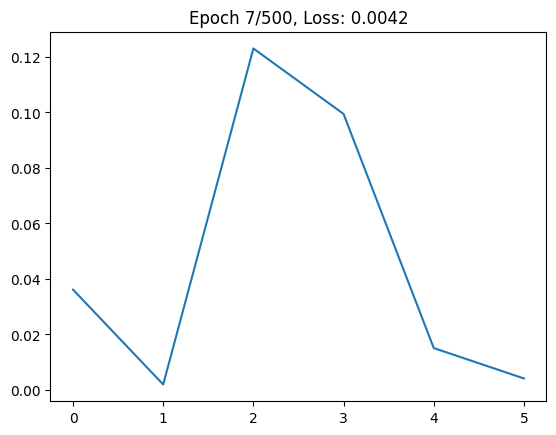

GPU Memory Usage>>>> Allocated: 1196.79 MB |||||  Reserved:  6432.00 MB:


KeyboardInterrupt: 

In [29]:
model.config.use_cache = False
model.config.pretraining_tp = 1
gradient_accumulation_steps = 4
max_steps=500
max_loss = 1e9

from torch.optim import AdamW
from bitsandbytes.optim import Adam8bit,PagedAdam32bit
# Define optimizer
params_to_optimize = list(filter(lambda p: p.requires_grad, model.parameters()))
# optimizer = AdamW(params_to_optimize, lr=1e-4)
# optimizer = Adam8bit(params_to_optimize, lr=1e-4)
optimizer = PagedAdam32bit(params_to_optimize, lr=1e-4)

# Training loop
model.train()

global_step= 0
running_loss = []

while global_step< max_steps:
    for step,batch in enumerate(train_dataloader):
        model.config.use_cache = False
        model.train()
        
        # Forward pass
        outputs = model(input_ids=batch['input_ids'].to('cuda'), attention_mask=batch['attention_mask'].to('cuda'), labels=batch['labels'].to('cuda'))
        loss = outputs.loss
        running_loss.append(loss.item())
        loss.backward()
        

        optimizer.step()
        optimizer.zero_grad()
        
        global_step += 1
        if global_step >= max_steps:
            break
        
        clear_output(wait=True)
        plt.plot(running_loss)
        plt.title(f"Epoch {global_step + 1}/{max_steps}, Loss: {loss.item():.4f}")
        plt.show()
        print_gpu_utilization()
 
        
flush()

In [18]:
flush()

In [19]:
print_gpu_utilization()

GPU Memory Usage>>>> Allocated: 1858.56 MB |||||  Reserved:  2478.00 MB:


In [20]:
pred = generate_eval(model=model,idx=4,disable_lora=False)
print(pred)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|> <|start_header_id|>user<|end_header_id|>

What were some of the key highlights of IPL 2024?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Some of the key highlights of IPL 2024 include Kolkata Knight Riders (KKR) winning the title, dominant performances from several teams and many high-scoring matches. Many individual players also showcased remarkable performances to help their teams win the championship. The tournament witnessed significant contributions from both batsmen and bow


In [21]:
small_dataset[4]

{'instruction': 'What were some of the key highlights of IPL 2024?',
 'output': 'Some of the key highlights of IPL 2024 include Kolkata Knight Riders (KKR) winning the tournament, dominant performances from several teams, remarkable individual performances from both batsmen and bowlers, and many high-scoring matches.'}

# Saving the LoRA Adapter

In [20]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 2048)
        (layers): ModuleList(
          (0-15): 16 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lor

In [58]:
model.save_pretrained('adapter')

In [59]:
del model
flush()

# Loading back the model and adding the LoRA adapter

In [17]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, get_scheduler,pipeline
from bitsandbytes.optim import Adam8bit,PagedAdam32bit
from peft import LoraConfig, get_peft_model, PeftModel, PeftConfig
from peft import prepare_model_for_kbit_training
import torch
from IPython.display import  clear_output
import time
import gc
from torch.utils.data import Dataset, DataLoader

def print_gpu_utilization():
    allocated = torch.cuda.memory_allocated() / (1024 ** 2)
    reserved = torch.cuda.memory_reserved() / (1024 ** 2)
    print(f"GPU Memory Usage>>>> Allocated: {allocated:.2f} MB |||||  Reserved:  {reserved:.2f} MB:")

def flush():
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

DEFAULT_MODEL = "meta-llama/Llama-3.2-1B-Instruct"

bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type='nf4',
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=False,
    )


model = AutoModelForCausalLM.from_pretrained(
    DEFAULT_MODEL,
    quantization_config=bnb_config,
    use_safetensors=True,
    device_map=device,
)

print(model.get_memory_footprint()/(1024*1024)) 

tokenizer = AutoTokenizer.from_pretrained(DEFAULT_MODEL, use_safetensors=True)
tokenizer.pad_token_id = tokenizer.eos_token_id
model.config.pad_token_id = tokenizer.eos_token_id


965.1290283203125


In [61]:
# Load the adapter into the base model
model = PeftModel.from_pretrained(model, 'adapter')
model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 3072)
        (layers): ModuleList(
          (0-27): 28 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3072, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lor

In [19]:
small_dataset[0]

{'instruction': 'Summarize the IPL 2024 season.',
 'output': 'The 2024 Indian Premier League (IPL) was a thrilling season filled with memorable moments, outstanding performances, and intense competition. Kolkata Knight Riders (KKR) emerged as the champions, defeating Sunrisers Hyderabad (SRH) in the final. The season witnessed remarkable individual performances, high-scoring matches, and competitive qualifier stages.'}

In [69]:
llama_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

messages = [
    {"role": "user", "content": "Who is gonna win IPL?"}
]

generated_text = llama_pipeline(messages, max_new_tokens=60, early_stopping=True)

print(generated_text[0]['generated_text'][-1]['content'])

Device set to use cuda
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausalLM', 'GotOcr2ForConditionalGeneration', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForC

The Indian Premier League (IPL) is an ongoing and dynamic competition, and the outcome of the tournament can change rapidly. As of my knowledge cutoff in December 2023, the teams that were likely to perform well in the upcoming season included the Royal Challengers Bangalore, the Chennai Super Kings,
